# Performance Evaluation

### Import modules & Load Dataset

In [1]:
!pip install pyecharts
from pyecharts import options as opts
from pyecharts.charts import Surface3D
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.utils.data as Data
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import torch.nn.functional as F
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

In [3]:
df = pd.read_excel("Z:/Programing_Space/DataSpell_Workspace/Research_UCSC_Marine/3_Machine_Learning/Data Engineering/raw_data.xlsx", sheet_name="species_heights")
df = df[["intertidal_sitename","Mean(z_rock_height)","species_lump","x_transect","location"]] # drop useless cols

In [4]:
# check the species breakdown for each site
eda_df = df.copy()
spec_list = eda_df["species_lump"].unique().tolist()
site_list = eda_df["intertidal_sitename"].unique().tolist()
eda_df_01 = pd.DataFrame()
eda_df_01["species"] = spec_list
for site in site_list:
    check_list = []
    for spec in spec_list:
        if spec in eda_df.loc[eda_df["intertidal_sitename"]==site]["species_lump"].tolist():
            check_list.append("Yes")
        else:
            check_list.append(None)
    eda_df_01[site] = check_list
eda_df_01.dropna(inplace=True)
species_list = eda_df_01["species"].to_list()
# generate species_list except for "Other Species"
species_list.remove("Other Species")
# Create two categories for modeling
df["species_cat_01"] = df["species_lump"].apply(lambda x: "Other Species" if x not in species_list else "Focus Species")
df["species_cat_02"] = df["species_lump"].apply(lambda x: "Other Species" if x not in species_list else x)

df

,intertidal_sitename,Mean(z_rock_height),species_lump,x_transect,location,species_cat_01,species_cat_02
0,Bob Creek,4.052500,Balanus glandula,0.0,0.00,Focus Species,Balanus glandula
1,Bob Creek,4.044423,Balanus glandula,0.0,0.33,Focus Species,Balanus glandula
2,Bob Creek,4.036170,Other Species,0.0,0.66,Other Species,Other Species
3,Bob Creek,4.027484,Other Species,0.0,1.00,Other Species,Other Species
4,Bob Creek,4.018874,Other Species,0.0,1.33,Other Species,Other Species
...,...,...,...,...,...,...,...
53666,White Point,1.909853,Mytilus californianus,30.0,28.50,Focus Species,Mytilus californianus
53667,White Point,1.944892,Other Species,30.0,28.75,Other Species,Other Species
53668,White Point,1.980000,Other Species,30.0,29.00,Other Species,Other Species
53669,White Point,2.049914,Balanus glandula,30.0,29.25,Focus Species,Balanus glandula


### Load Pre-trained Model

#### Phase I modeling

In [5]:
class Phase_1_Net(nn.Module):
    # Networks
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1,16)
        self.hidden2 = nn.Linear(16,32)
        self.hidden3 = nn.Linear(32,16)
        self.out = nn.Linear(16,2)
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    # Feed Forward
    def forward(self, x):
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden3(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [6]:
phase_1_net = Phase_1_Net().to(device) # Create a net instance
phase_1_net

Phase_1_Net(
  (hidden1): Linear(in_features=1, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=2, bias=True)
  (activation): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [7]:
phase_1_net.load_state_dict(torch.load("Z:/Programing_Space/DataSpell_Workspace/Research_UCSC_Marine/3_Machine_Learning/Phase I Modeling/Phase I - Species Distribution Model.pth"))

<All keys matched successfully>

#### Phase II Modeling

In [8]:
class Phase_2_Net(nn.Module):
    # Networks
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1,16)
        self.hidden2 = nn.Linear(16,32)
        self.hidden3 = nn.Linear(32,16)
        self.out = nn.Linear(16,5)
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    # Feed Forward
    def forward(self, x):
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden3(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [9]:
phase_2_net = Phase_2_Net().to(device) # Create a net instance
phase_2_net

Phase_2_Net(
  (hidden1): Linear(in_features=1, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=5, bias=True)
  (activation): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [10]:
phase_2_net.load_state_dict(torch.load("Z:/Programing_Space/DataSpell_Workspace/Research_UCSC_Marine/3_Machine_Learning/Phase II Modeling/Phase II - Species Distribution Model.pth"))

<All keys matched successfully>

#### Data Loader

In [11]:
input_x = np.array(df["Mean(z_rock_height)"].tolist())
scaler_func = StandardScaler()
input_x = scaler_func.fit_transform(input_x.reshape(-1,1)).astype(np.float32)
input_x = torch.FloatTensor(input_x)

In [12]:
phase_1_prediction_list = []
phase_2_prediction_list = []


phase_1_net.eval()
phase_2_net.eval()

for feature in input_x:
    x_input = feature.to(device)
    # === phase 1 modeling
    y_pred_phase_1 = phase_1_net(x_input)
    y_pred_phase_1 = F.softmax(y_pred_phase_1, dim=0)
    y_pred_phase_1 = y_pred_phase_1.data.cpu().numpy().squeeze().tolist()
    phase_1_prediction_list.append(y_pred_phase_1)
    # === phase 2 modeling
    y_pred_phase_2 = phase_2_net(x_input)
    y_pred_phase_2 = F.softmax(y_pred_phase_2, dim=0)
    y_pred_phase_2 = y_pred_phase_2.data.cpu().numpy().squeeze().tolist()
    phase_2_prediction_list.append(y_pred_phase_2)

### Consolidate modeling result

In [13]:
df["phase_1_pred"] = phase_1_prediction_list
df["phase_1_porb_foucs"] = df["phase_1_pred"].apply(lambda x: x[0])
df["phase_1_porb_other"] = df["phase_1_pred"].apply(lambda x: x[1])

df["phase_2_pred"] = phase_2_prediction_list
df["Mytilus californianus"] = df["phase_2_pred"].apply(lambda x: x[0])
df["Anthopleura elegantissima"] = df["phase_2_pred"].apply(lambda x: x[1])
df["Balanus glandula"] = df["phase_2_pred"].apply(lambda x: x[2])
df["Egregia menziesii"] = df["phase_2_pred"].apply(lambda x: x[3])
df["Pollicipes polymerus"] = df["phase_2_pred"].apply(lambda x: x[4])

del df["phase_1_pred"]
del df["phase_2_pred"]



In [14]:
# phase 1 result
data = df.copy()
data["phase_1_result"] = df["phase_1_porb_foucs"] - df["phase_1_porb_other"]
data["phase_1_result"] = data["phase_1_result"].apply(lambda x: "Focus" if x > 0 else "Other Species")
phase_2_df = data[["Mytilus californianus","Anthopleura elegantissima","Balanus glandula","Egregia menziesii",
                               "Pollicipes polymerus"]]
# phase 2 result
phase_2_df["pred_result"] = phase_2_df.idxmax(axis = 1)
df["phase_1_result"] = data["phase_1_result"]
df["phase_2_result"] = phase_2_df["pred_result"]
# gain final result
final_result = []
for i in range(len(df)):
    if df.iloc[i]["phase_1_result"] == "Focus":
        final_result.append(df.iloc[i]["phase_2_result"])
    else:
        final_result.append("Other Species")
df["model_pred_result"] = final_result
# accuracy
df["accuracy"] = np.where(df["species_cat_02"]==df["model_pred_result"],"Y","N")

df.to_csv("Neural_Networks_Pred_Result.csv", index = None)

### Overall Multiclassification Accuracy

In [15]:
evaluation_df = df.copy()[["species_cat_02","model_pred_result"]]

mapping_dict = {'Mytilus californianus': 0,
                'Anthopleura elegantissima': 1,
                'Balanus glandula': 2,
                'Egregia menziesii': 3,
                'Pollicipes polymerus': 4,
                'Other Species':5}

evaluation_df["y_true"] = evaluation_df["species_cat_02"].apply(lambda x: mapping_dict[x])
evaluation_df["y_pred"] = evaluation_df["model_pred_result"].apply(lambda x: mapping_dict[x])

y_true_lst = evaluation_df["y_true"].tolist()
y_pred_lst = evaluation_df["y_pred"].tolist()

print("Accuracy Score: ", accuracy_score(y_true_lst, y_pred_lst))
print("Precision Score: ", precision_score(y_true_lst, y_pred_lst, average='macro'))
print("Recall Score: ", recall_score(y_true_lst, y_pred_lst, average='macro'))
print("F1 Score: ", f1_score(y_true_lst, y_pred_lst, average='macro'))
print("Baseline Accuracy: ", 1/6) # 6 category multiclass


Accuracy Score:  0.5274170408600548
Precision Score:  0.21097819108440055
Recall Score:  0.2555209307521005
F1 Score:  0.20048163756508494
Baseline Accuracy:  0.16666666666666666


### Heatmap Visualization

In [16]:
heatmap_visual = df.copy()
heatmap_visual["Mytilus californianus prob"] = heatmap_visual["Mytilus californianus"] * heatmap_visual["phase_1_porb_foucs"]
heatmap_visual["Anthopleura elegantissima prob"] = heatmap_visual["Anthopleura elegantissima"] * heatmap_visual["phase_1_porb_foucs"]
heatmap_visual["Balanus glandula prob"] = heatmap_visual["Balanus glandula"] * heatmap_visual["phase_1_porb_foucs"]
heatmap_visual["Egregia menziesii prob"] = heatmap_visual["Egregia menziesii"] * heatmap_visual["phase_1_porb_foucs"]
heatmap_visual["Pollicipes polymerus prob"] = heatmap_visual["Pollicipes polymerus"] * heatmap_visual["phase_1_porb_foucs"]

In [17]:
heatmap_visual = heatmap_visual[["intertidal_sitename","x_transect","location","Mytilus californianus prob",
                                 "Anthopleura elegantissima prob","Balanus glandula prob","Egregia menziesii prob",
                                 "Pollicipes polymerus prob"]]
heatmap_visual

,intertidal_sitename,x_transect,location,Mytilus californianus prob,Anthopleura elegantissima prob,Balanus glandula prob,Egregia menziesii prob,Pollicipes polymerus prob
0,Bob Creek,0.0,0.00,0.154513,0.041296,0.322194,0.000868,0.084697
1,Bob Creek,0.0,0.33,0.154566,0.041330,0.322049,0.000870,0.084744
2,Bob Creek,0.0,0.66,0.154621,0.041364,0.321899,0.000871,0.084793
3,Bob Creek,0.0,1.00,0.154679,0.041401,0.321739,0.000873,0.084844
4,Bob Creek,0.0,1.33,0.154738,0.041439,0.321578,0.000874,0.084896
...,...,...,...,...,...,...,...,...
53666,White Point,30.0,28.50,0.151549,0.118961,0.091029,0.015395,0.147093
53667,White Point,30.0,28.75,0.156123,0.117097,0.096648,0.013891,0.147788
53668,White Point,30.0,29.00,0.160395,0.114982,0.102469,0.012534,0.148078
53669,White Point,30.0,29.25,0.167878,0.110179,0.114607,0.010229,0.147534


In [191]:
def heatmap_visualization(site,spec,heatmap_visual):
    tester = heatmap_visual.copy()
    tester = tester.loc[tester["intertidal_sitename"] == site]
    tester = tester[["x_transect","location",spec]]
    
    col_x = sorted(list(set(tester["x_transect"].tolist())))
    col_y = sorted(list(set(tester["location"].tolist())))
    
    
    visual_df = pd.DataFrame(columns = col_x, index = col_y)
    for i in range(len(tester)):
        visual_df.at[tester.iloc[i]["location"],tester.iloc[i]["x_transect"]] = tester.iloc[i][spec]
    visual_df.fillna(0,inplace=True)
    plt.figure(figsize=(5, 4), dpi=100)
    plt.imshow(visual_df,aspect='auto', cmap='ocean', interpolation='spline16')
    plt.colorbar()
    plt.title(site + " - HeatMap of Species Distribution\n" + spec, fontsize = 10)
    plt.show()

In [192]:
sitelist = list(set(heatmap_visual["intertidal_sitename"].tolist()))
spec_list = ["Mytilus californianus prob","Anthopleura elegantissima prob","Balanus glandula prob",
             "Egregia menziesii prob","Pollicipes polymerus prob"]

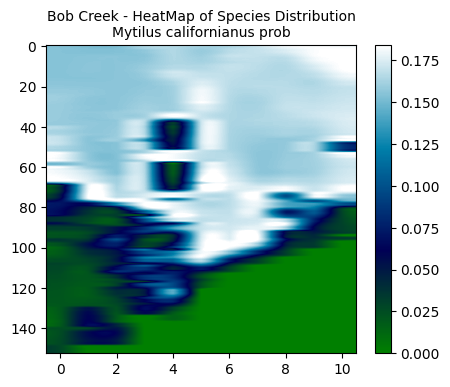

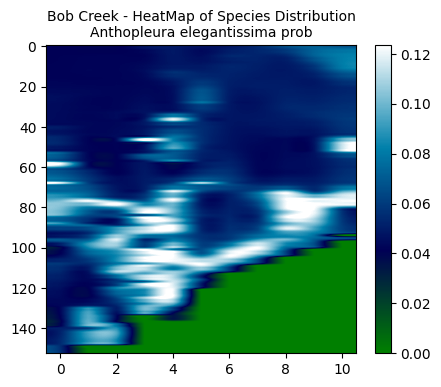

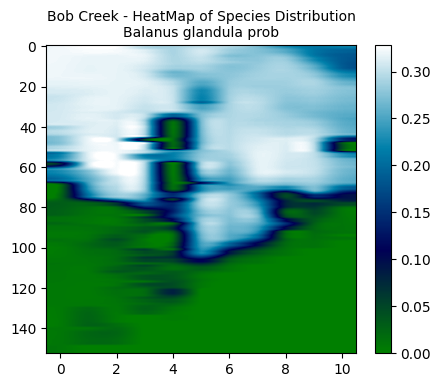

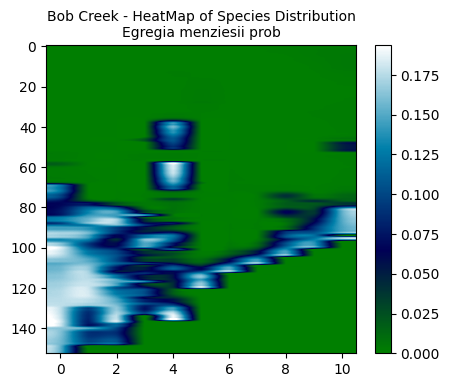

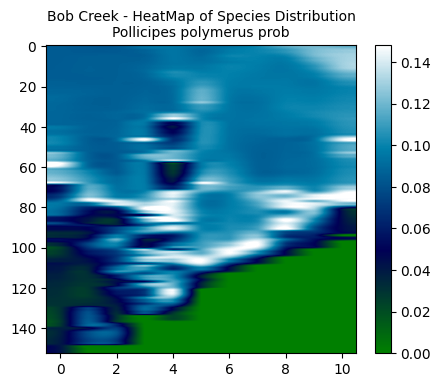

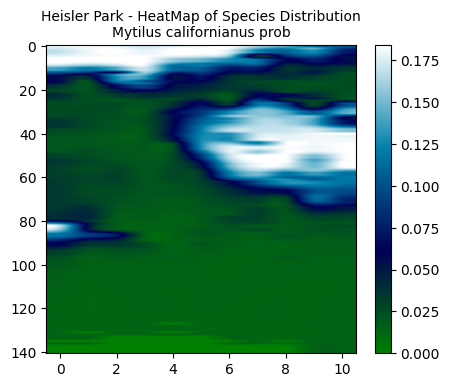

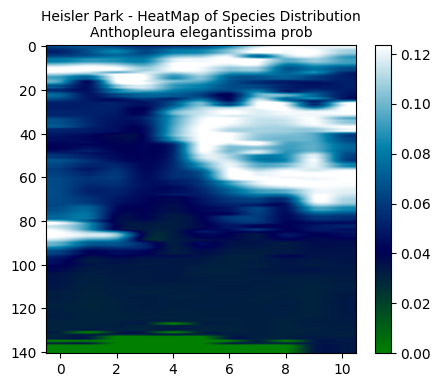

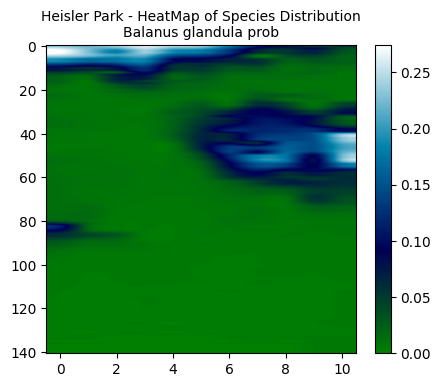

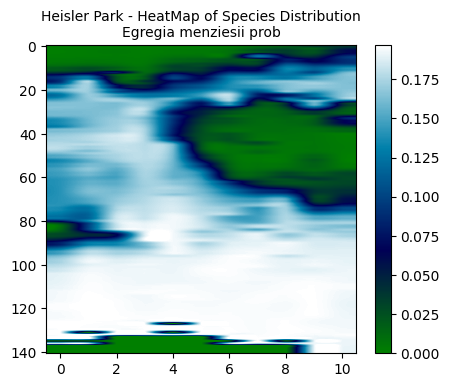

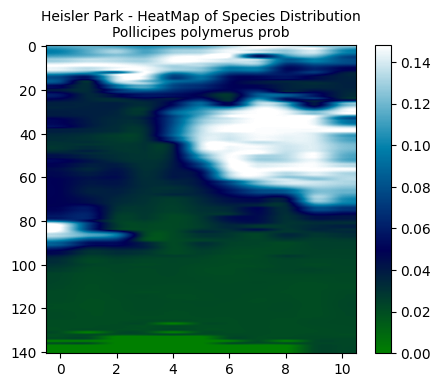

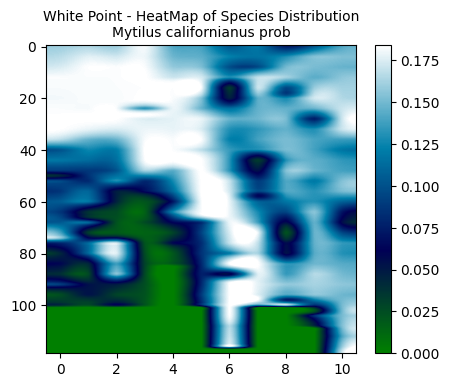

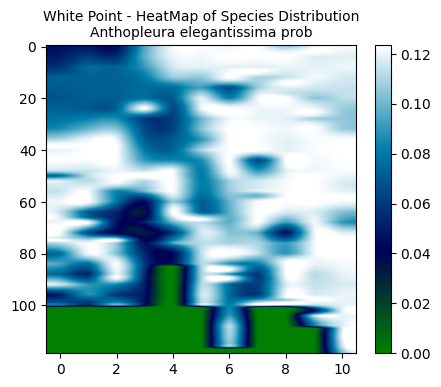

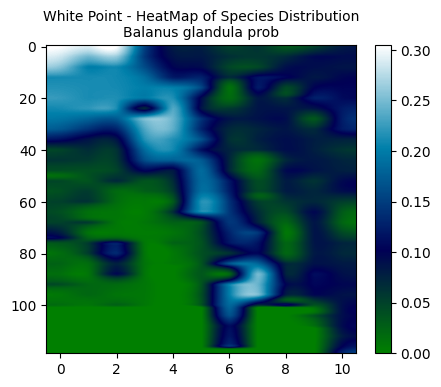

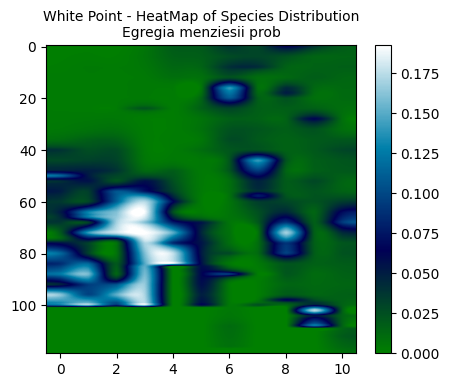

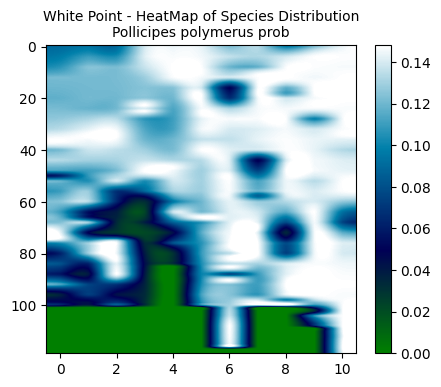

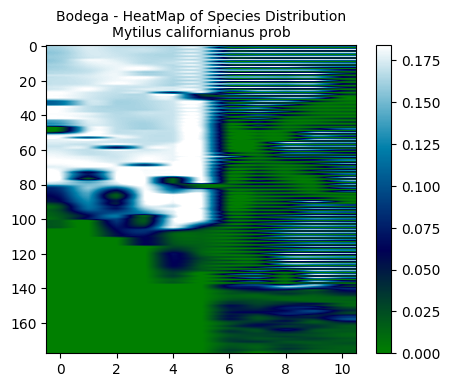

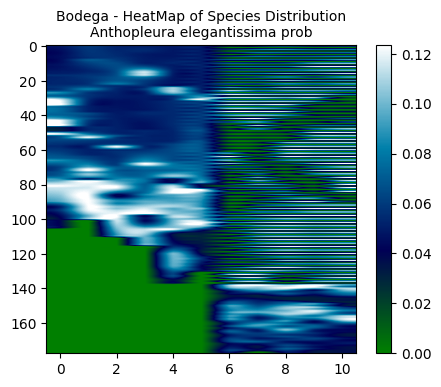

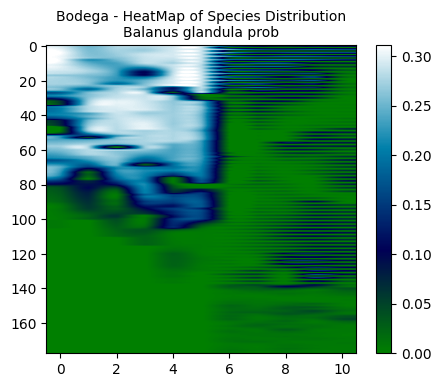

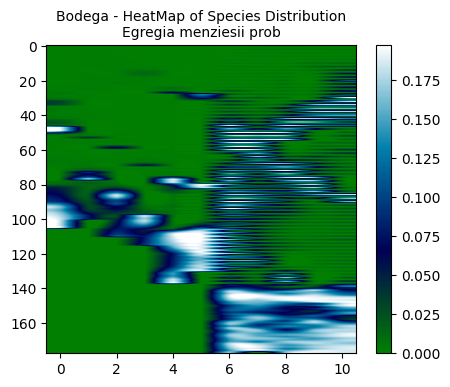

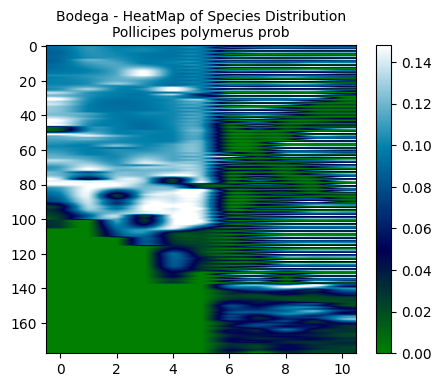

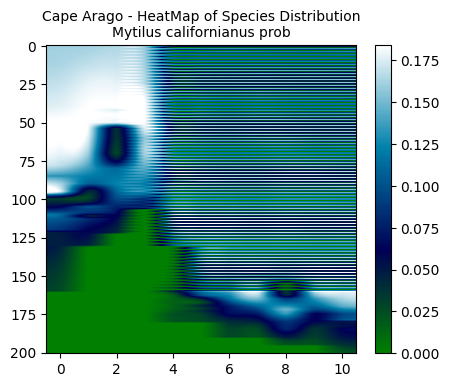

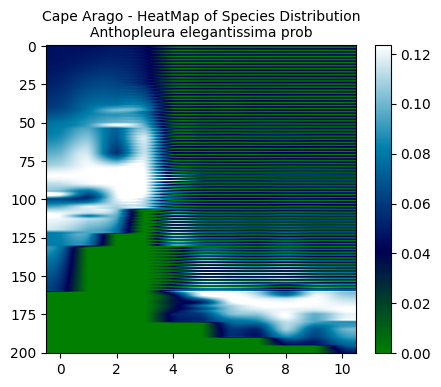

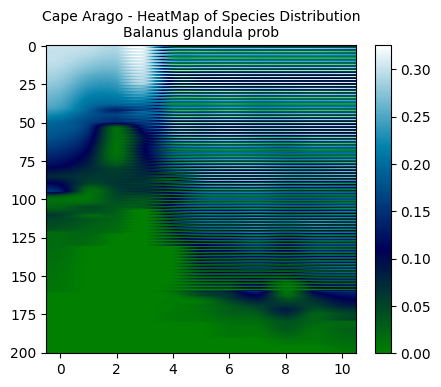

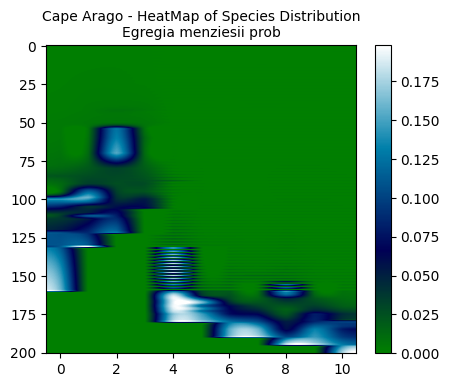

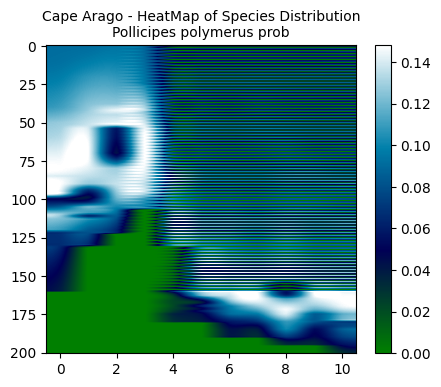

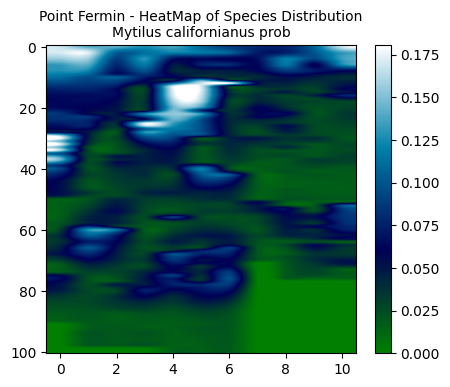

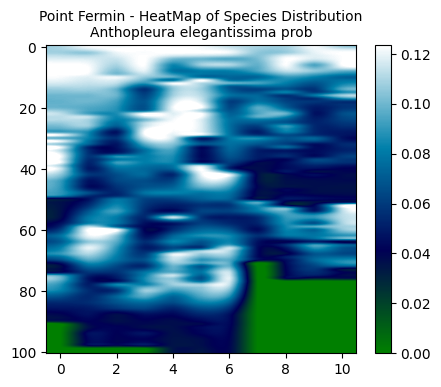

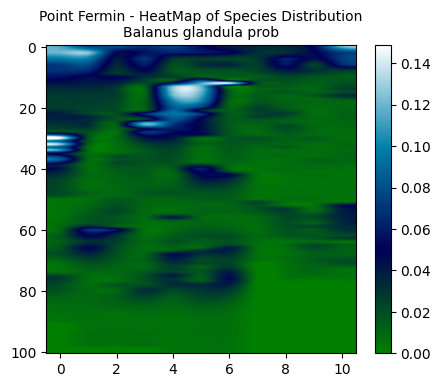

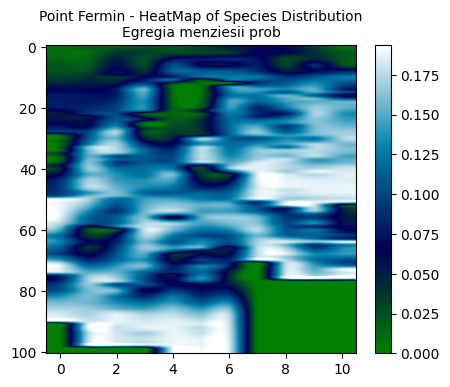

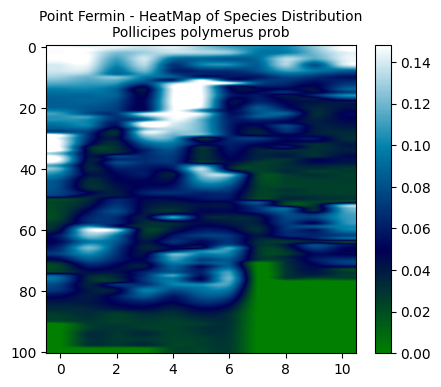

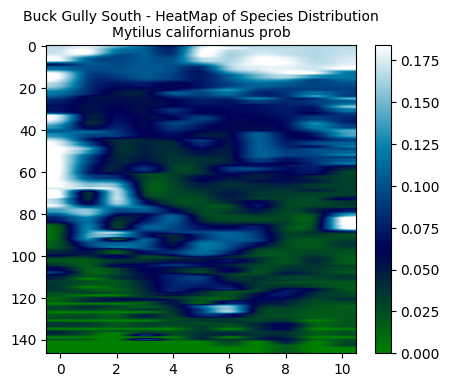

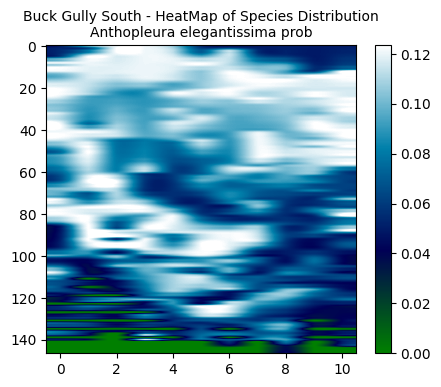

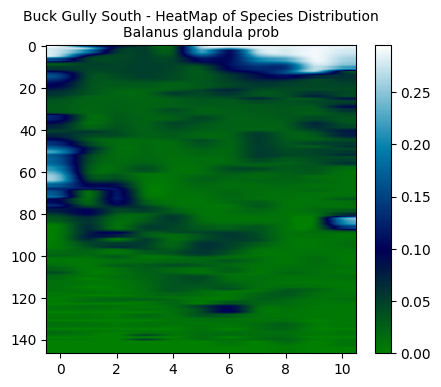

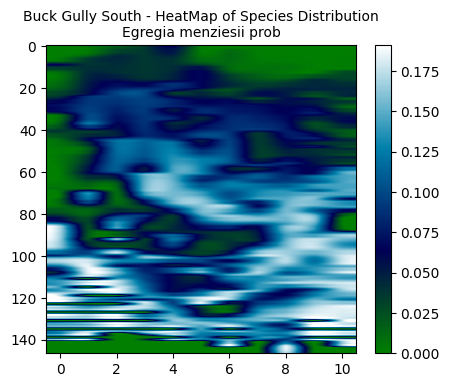

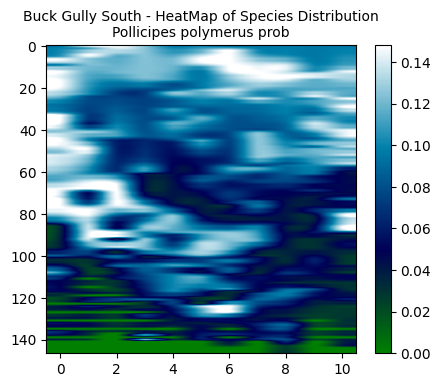

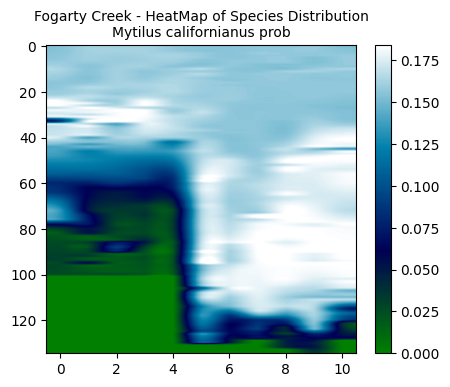

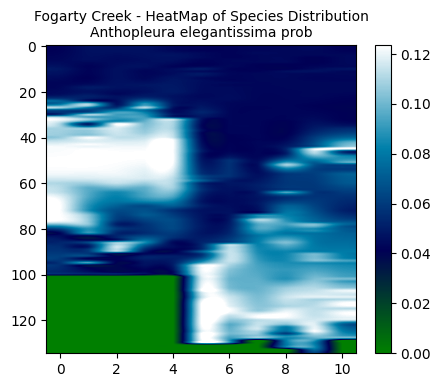

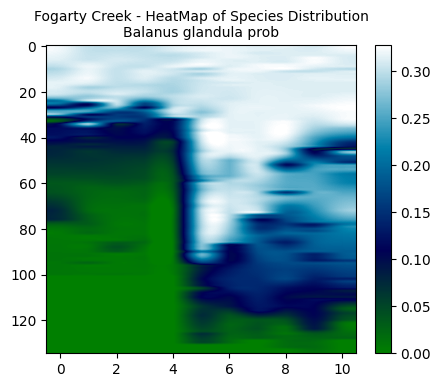

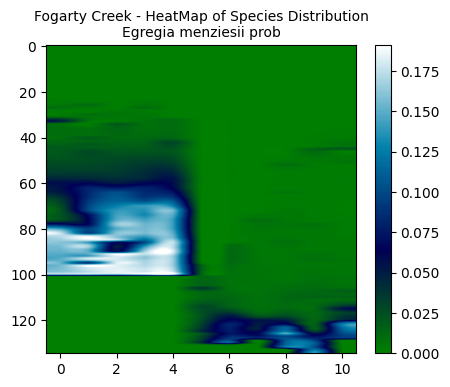

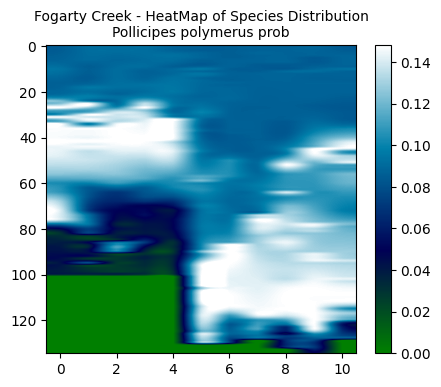

In [193]:
for site_val in sitelist:
    for spec_val in spec_list:
        heatmap_visualization(site_val,spec_val,heatmap_visual)